In [36]:
#author = 0712238@NCTU, Maxwill Lin, YT Lin
#last update = 2019.11.6-7
#usage = HW1 of Deep Learning 2019 fall @ NCTU ,problem 1-c
#regression experiments
#preprocess with normaliztion and one-hot vectorization
#NN architectur = NN([exp, 10, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
#train and test with split data set
#learning curve + train/test RMS
#importance ranking with measurement = avg test RMS over 10 experiments(each exp try until get a valid network)
#result and validation visualized

In [2]:
import numpy as np
import math
import pandas as pd
from model import *
import csv
import matplotlib.pyplot as plt
import pickle

In [3]:
#preprocessing
df = pd.read_csv("EnergyEfficiency_data.csv")
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [6]:
def get_onehot(df, name):
    A = df[name].values
    n = A.shape[0]
    onehot_A = np.zeros((n,max(A)-min(A)+1))
    onehot_A[np.arange(n), A-min(A)] = 1
    return onehot_A

def normalize(X):
    s = [ np.mean(dim) for dim in X.T]
    X = np.asarray([np.divide(x, s) for x in X])
    return X

O = get_onehot(df, "Orientation")
G = get_onehot(df, "Glazing Area Distribution")
y = df["Heating Load"].values.reshape((-1,1))
Other_df = df.drop(['Orientation', 'Glazing Area Distribution', "Heating Load"], axis=1)

n_feature = df.values.shape[1]-1

Xs = []

dropc = df.drop(["Heating Load"], axis=1).columns
print(dropc)

for col in dropc: #drop 1 except for heating load
    #print(col)
    if not col in ['Orientation', 'Glazing Area Distribution', "Heating Load"]:
        TMP = Other_df.drop([col], axis=1) #print(TMP)
    Xi = normalize(TMP.values)
    if col != 'Orientation':
        Xi = np.c_[Xi, O]
    if col != 'Glazing Area Distribution':
        Xi = np.c_[Xi, G]
    Xs.append(Xi)

assert(len(Xs) == n_feature)

def partition(X, y, ratio=0.75):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    p = int(n*ratio)
    train_X = X[:p]
    test_X = X[p:]
    train_y = y[:p]
    test_y = y[p:]
    return train_X, train_y, test_X, test_y

#train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Cooling Load'],
      dtype='object')


In [7]:
experiment_times = 10

SumOftestRMSs = np.zeros(n_feature)

NNs = []
trainRMSs = []
testRMSs = []
LCs = []

for T in range(experiment_times):
    NNs = []
    trainRMSs = []
    testRMSs = []
    LCs = []
    print("EXP #{}".format(T+1))
    for i in range(n_feature):
        #print("trainning Network with feature ", dropc[i], " dropped")

        train_X, train_y, test_X, test_y = partition(Xs[i], y, ratio=0.75)
        
        #check change rate to ensure trained network is valid
        diff = 0
        eps = 0.03 
        r = 0
        Mr = 10
        savecurve = []
        saveNNi = None
        minRMS = 100.
        while diff < eps and r < Mr:
            r += 1
            NNi = NN([Xs[i].shape[1], 10, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
            learning_curve = NNi.train(train_X, train_y, epochs=80, batch_size=10, lr = .1)
            diff = (learning_curve[0] - learning_curve[-1])/learning_curve[-1]
            if learning_curve[-1] < minRMS:
                savecurve = learning_curve
                minRMS = learning_curve[-1]
                saveNNi = NNi
                
        LCs.append(savecurve)
        trainRMSs.append(saveNNi.calc_error(train_X, train_y))
        testRMSs.append(saveNNi.calc_error(test_X, test_y))
        NNs.append(saveNNi)
        SumOftestRMSs[i] += testRMSs[i]
    

EXP #1
EXP #2
EXP #3
EXP #4
EXP #5
EXP #6
EXP #7
EXP #8
EXP #9
EXP #10


importance ranking: (measurement = avg test RMS over 10 experiments)
Cooling Load 3.1081027708223674
Glazing Area Distribution 2.2357123204932376
Glazing Area 1.8342495308062439
Orientation 1.7347839493490713
Roof Area 1.63802067481079
Wall Area 1.6229074887078756
Relative Compactness 1.6094875172643544
Overall Height 1.6090780927448403
Surface Area 1.6076750547309824


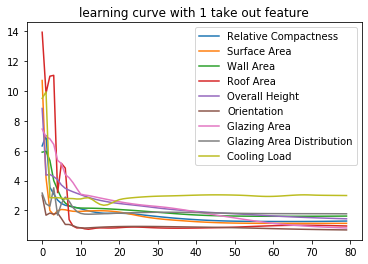

In [38]:
for i in range(n_feature):
    #print("Case #{}:".format(i+1))
    #print("take off feature ", dropc[i])
    plt.title("learning curve with 1 take out feature")
    plt.plot(np.arange(len(LCs[i])), LCs[i], label=dropc[i])
    plt.legend(loc='upper right')
    #print('train_RMS = ', trainRMSs[i], '\n', 'test_RMS = ', testRMSs[i])
    #print('mean test_RMS = ', SumOftestRMSs[i]/experiment_times)
plt.savefig('./plts/exp_result.png')

assert(len(testRMSs) == len(dropc))
#print(dropc)
#print(sorted(testRMSs))
#importance = dropc[sorted(range(len(testRMSs)), key=lambda x: testRMSs[x], reverse = True)]
importance = dropc[sorted(range(SumOftestRMSs.shape[0]), key=lambda x: SumOftestRMSs[x], reverse = True)]
print("importance ranking: (measurement = avg test RMS over 10 experiments)")
for item, i  in zip(list(importance), sorted(range(SumOftestRMSs.shape[0]), key=lambda x: SumOftestRMSs[x], reverse = True)):
    print(item, SumOftestRMSs[i]/experiment_times)

In [30]:
feature_selected = list(importance)[:5]

df_selected = Other_df
X_selected = None

for col in df.columns: #drop 1 except for heating load
    #print(col)
    if not col in feature_selected + ['Orientation', 'Glazing Area Distribution', 'Heating Load']:
        df_selected = df_selected.drop([col], axis=1) #print(TMP)
        
X_selected = normalize(df_selected.values)
if 'Orientation' in feature_selected:
    X_selected = np.c_[X_selected, O]
if 'Glazing Area Distribution' in feature_selected:
    X_selected = np.c_[X_selected, G]
    
train_X, train_y, test_X, test_y = partition(X_selected, y, ratio=0.75)

nn = NN([X_selected.shape[1], 10, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
#the network architecture is as the constructer

learning_curve = nn.train(train_X, train_y, epochs=70, batch_size=10, lr = .1)
train_RMS = nn.calc_error(train_X, train_y)
test_RMS = nn.calc_error(test_X, test_y)
print("\nModel top5")
print('train_RMS = ', train_RMS, '\n', 'test_RMS = ', test_RMS)

Other = df.drop(['Orientation', 'Glazing Area Distribution', "Heating Load"], axis=1).values
X = np.c_[normalize(Other), O, G]
train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)

nnall = NN([X.shape[1], 10, 10, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
#the network architecture is as the constructer
learning_curve2 = nnall.train(train_X, train_y, epochs=70, batch_size=10, lr = .1)
train_RMS2 = nnall.calc_error(train_X, train_y)
test_RMS2 = nnall.calc_error(test_X, test_y)

print("\nModel ALL")
print('train_RMS = ', train_RMS2, '\n', 'test_RMS = ', test_RMS2)


Model top5
train_RMS =  1.6645487550873261 
 test_RMS =  1.9800805121673237

Model ALL
train_RMS =  1.397763081604207 
 test_RMS =  1.5965314371853951



Model top5
train_RMS =  1.6645487550873261 
 test_RMS =  1.9800805121673237

Model ALL
train_RMS =  1.397763081604207 
 test_RMS =  1.5965314371853951


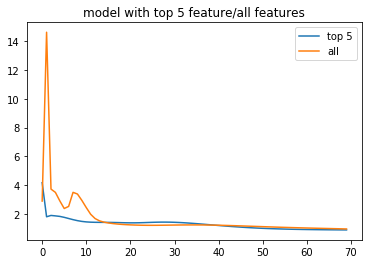

In [39]:
print("\nModel top5")
print('train_RMS = ', train_RMS, '\n', 'test_RMS = ', test_RMS)
print("\nModel ALL")
print('train_RMS = ', train_RMS2, '\n', 'test_RMS = ', test_RMS2)

plt.title("model with top 5 feature/all features")
plt.plot(np.arange(len(learning_curve)), learning_curve, label='top 5')
plt.plot(np.arange(len(learning_curve2)), learning_curve2, label='all')
plt.legend(loc='upper right')
plt.savefig('./plts/exp_validation.png')


In [34]:
print('top 5 feature selected by the measurment can do almost as good as all feature model')

top 5 feature selected by the measurment can do almost as good as all feature model
